# **Convolutional Network Example**

Author: PhD. Edwyn Javier Aldana
---



## **0. Loading Libraries**

In [1]:
import cv2
import os
import random
import numpy as np
from keras_preprocessing.image import ImageDataGenerator
import re
import pandas as pd



##**1. Load Dataset**
Now, we will load the data from the server. For this, we assume that the file containing all images has been previously copied to our drive.

**Warning:** Follow the instructions of the teacher before executing this cell

In [13]:
###############################################
#Mount a directory on server in order to upload 
#dataset
###############################################
from google.colab import drive
drive.mount('/content/drive/')
%cd '/content/drive/My Drive/Colab Notebooks/data' 

###################################
#Unzip our zip file that contains 
#our dataset
###################################
#!unzip 'miml_dataset'
#!tar -xvf  'images.tar.gz' #For a tar file

###################################
#Change the directory
###################################
%cd 'miml_dataset'


'/content/drive/MyDrive/Colab Notebooks/data/miml_dataset'

## **2. Define training, validation and test datasets**

###**Load name files and class names from a CSV File**

In [15]:
columns=["desert", "mountains", "sea", "sunset", "trees"]
df=pd.read_csv('miml_labels_1.csv')
df.head()




,Filenames,desert,mountains,sea,sunset,trees
0,1.jpg,1,0,0,0,0
1,2.jpg,1,0,0,0,0
2,3.jpg,1,0,0,0,0
3,4.jpg,1,1,0,0,0
4,5.jpg,1,0,0,0,0


### **Some examples of our dataset**

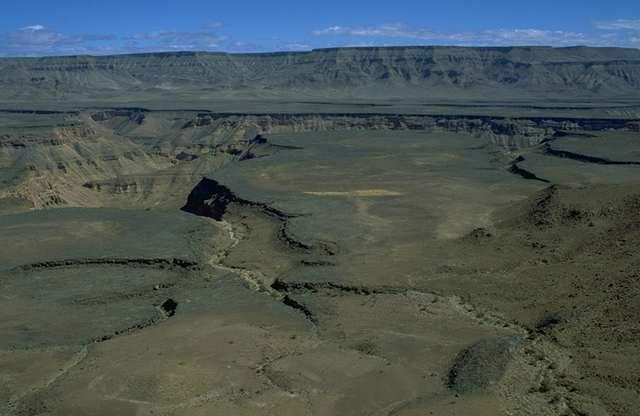

---




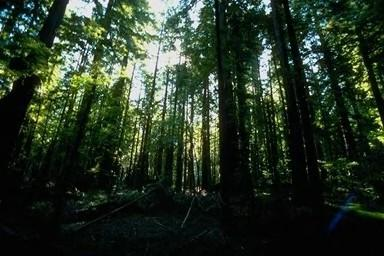
---



### **Computational representation of a RGB image**

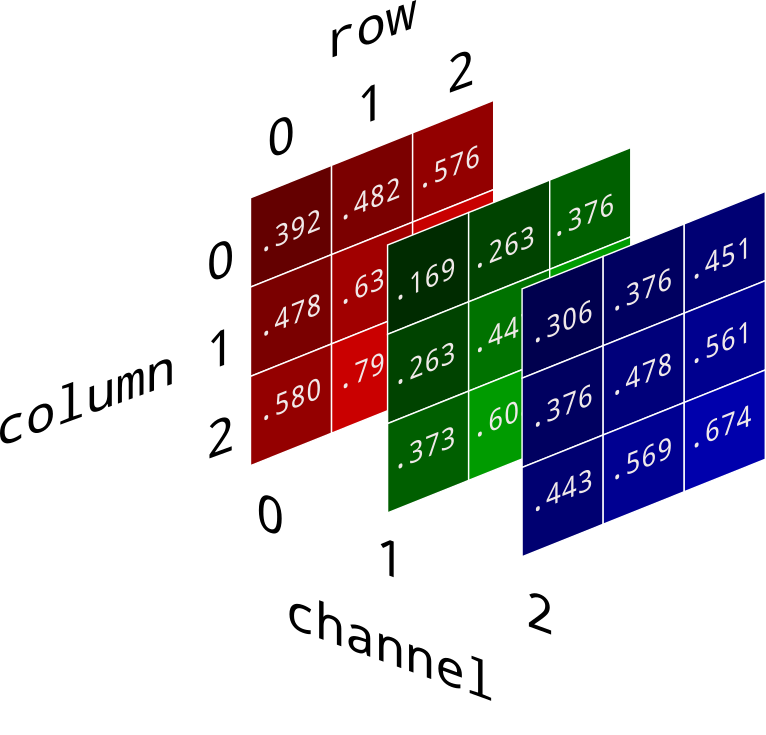

## **Prepare train and test datasets**

Recall that originally the images in our dataset have different sizes. 

In [16]:
#Rescale pixel values (0-1 values)
train_datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

#A generator creates an optimal structure in terms of memory
#to load the images.
#The generator also allows us to change the size of the images,
#in this case our  images will be resized to 64X64.
train_generator=train_datagen.flow_from_dataframe(
dataframe=df[:1800],
directory="images",
x_col="Filenames",
y_col=columns, #array previously created
batch_size=16,
seed=42,
shuffle=True,
class_mode="raw", #numpy array of values in y_col column(s)
target_size=(64,64))

valid_generator=test_datagen.flow_from_dataframe(
dataframe=df[1800:1900],
directory="images",
x_col="Filenames",
y_col=columns,
batch_size=8,
seed=42,
shuffle=True,
class_mode="raw", #Clases 
target_size=(64,64))

test_generator=test_datagen.flow_from_dataframe(
dataframe=df[1900:],
directory="images",
x_col="Filenames",
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=(64,64))

Found 1800 validated image filenames.
Found 100 validated image filenames.
Found 100 validated image filenames.


# **2. Designing a Convolutional Network**

In [18]:
#Additional libraries
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers, Sequential

**The architecture of our network**

**1. Input layer**
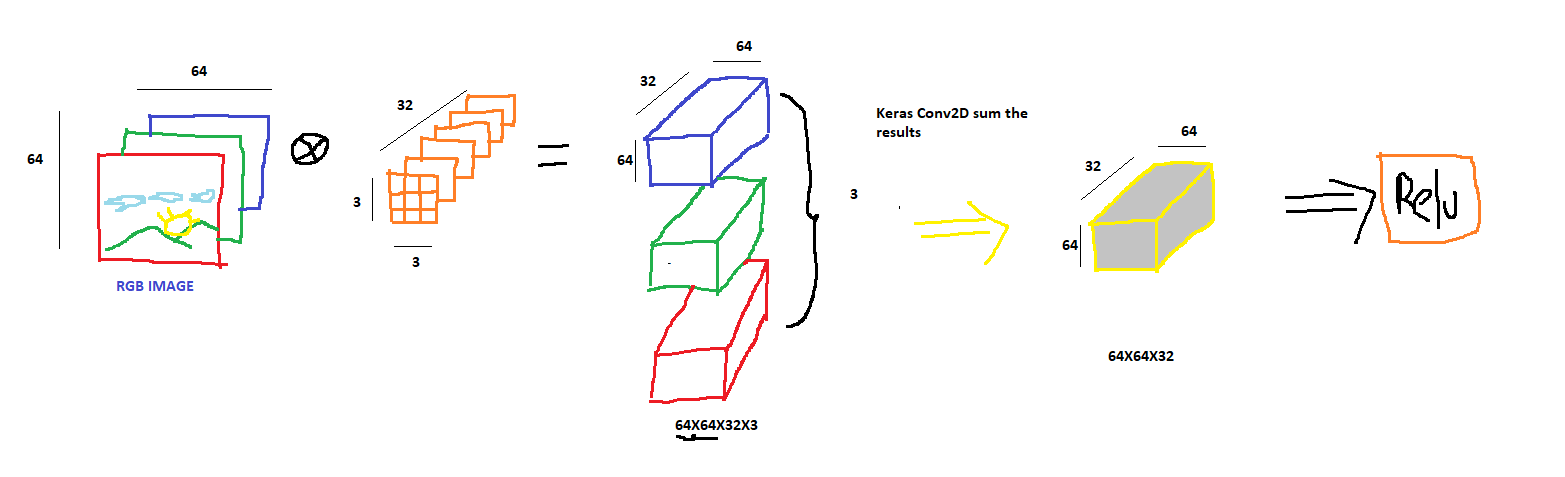

In [26]:
#Input of the network
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', 
                 input_shape=(64,64,3)))
#padding='same|valid->zero padding, no padding'
model.add(Activation('relu'))



**2. Convolution Layer**
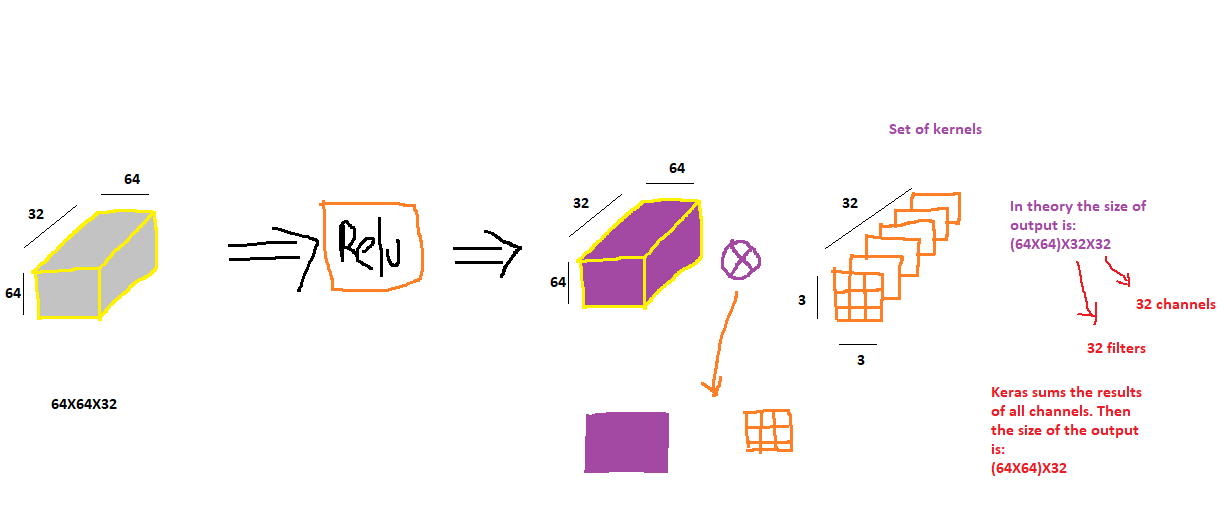

In [27]:
#Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))

#Pooling Layer
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#Output layer, this depends on the number of classes,
#in our example we have 5 classes
model.add(Dense(5, activation='sigmoid'))
model.summary()
#Several hyper-parameters
model.compile(optimizers.RMSprop(lr=0.0001, decay=1e-6),loss="binary_crossentropy", metrics=["accuracy"])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 activation_10 (Activation)  (None, 64, 64, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_11 (Activation)  (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 32, 32, 32)        0         
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Calculating the number of parameters:

1.   **Convolution Layer:**

$channels(output) * (channels(input) * size(kernel) + 1) = \#parameters$

2.   **For dense layers:**

$size(output)* (size(input) + 1) = \#parameters$ 


# **3. Training Network**

In [28]:

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size #1800/16=112.5
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size #100/8=12.5
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size    #100/1=100

history=model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=5
)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/5
112/112 [==============================] - 45s 372ms/step - loss: 0.4704 - accuracy: 0.4439 - val_loss: 0.3908 - val_accuracy: 0.6875
Epoch 2/5
112/112 [==============================] - 42s 371ms/step - loss: 0.3922 - accuracy: 0.5936 - val_loss: 0.3212 - val_accuracy: 0.6771
Epoch 3/5
112/112 [==============================] - 41s 365ms/step - loss: 0.3620 - accuracy: 0.6278 - val_loss: 0.2733 - val_accuracy: 0.7604
Epoch 4/5
112/112 [==============================] - 41s 369ms/step - loss: 0.3410 - accuracy: 0.6390 - val_loss: 0.3290 - val_accuracy: 0.6771
Epoch 5/5
112/112 [==============================] - 41s 368ms/step - loss: 0.3216 - accuracy: 0.6682 - val_loss: 0.2631 - val_accuracy: 0.7708


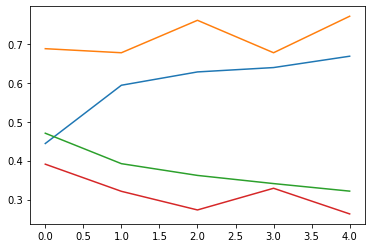

In [29]:
#plot learning curves
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

# **4. Prediction**

In [30]:
test_generator.reset()
pred=model.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)
#We obtain a probability vector (5-dimensional) for each test image
print(pred.shape)
pred[1]



  1/100 [..............................] - ETA: 12s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


100/100 [==============================] - 2s 14ms/step
(100, 5)


array([0.04800561, 0.16592896, 0.8120008 , 0.03072309, 0.05988249],
      dtype=float32)

In [37]:
pred_bool = (pred >0.5)
predictions = pred_bool.astype(int)
columns=["desert", "mountains", "sea", "sunset", "trees"]
#columns should be the same order of y_col
results=pd.DataFrame(predictions, columns=columns)
results["Filenames"]=test_generator.filenames
ordered_cols=["Filenames"]+columns
results=results[ordered_cols]#To get the same column order
results.head()
#results.to_csv("results.csv",index=False)


,Filenames,desert,mountains,sea,sunset,trees
0,1901.jpg,0,0,1,0,0
1,1902.jpg,0,0,1,0,0
2,1903.jpg,0,0,0,0,1
3,1904.jpg,0,0,1,0,0
4,1905.jpg,0,0,0,0,1
